# Object detection & Semantic segmentation

Remark: you may not be able to run it unless you correctly install torchvision, opencv-python, pillow !

In [1]:
import numpy as np
from PIL import Image
import json
import torchvision
import cv2
import glob
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random

In [2]:
images_files = glob.glob('./test_dataset/*.jpg')
images_files

['./test_dataset/0a2cc187-8d6ab554.jpg',
 './test_dataset/0a0eaeaf-9ad0c6dd_3.jpg',
 './test_dataset/0a2cc187-8d6ab554_1.jpg',
 './test_dataset/0a3bb2d8-e2bd5aea.jpg',
 './test_dataset/0a2cc187-8d6ab554_3.jpg']

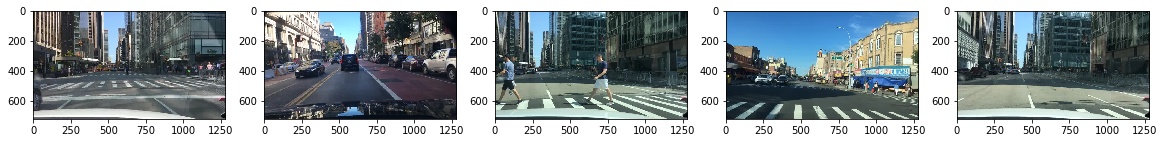

In [3]:
fig, axes = plt.subplots(1, len(images_files),figsize=(20,10))
[ax.imshow(Image.open(f)) for ax,f in zip(axes,images_files)]
plt.show()

## 1. Object detection with Faster RCNN

In [4]:
## Since the model is trained on COCO dataset, the true labels are following this sequence.

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [5]:
# This block will download the pretrained model into the default directory (around 140Mb)
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

/home/ai/.pyenv/versions/3.7.8/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


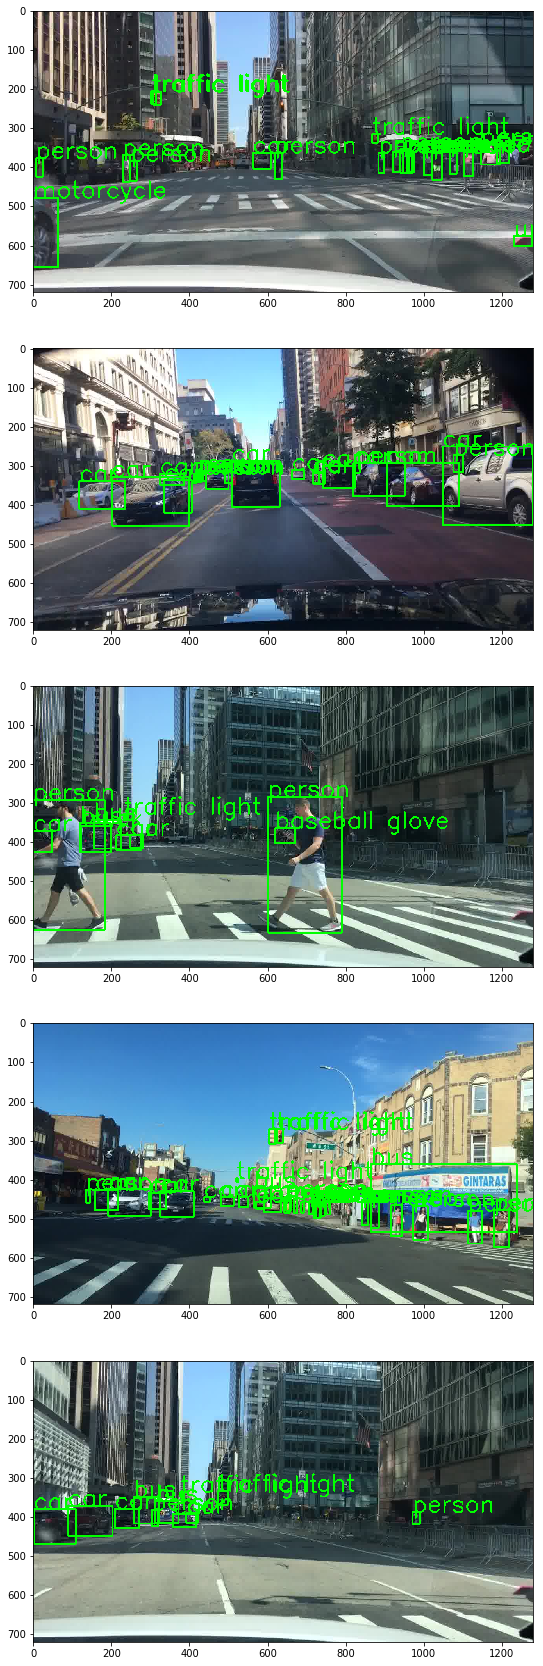

In [6]:
## Some helper functions to load the image and do the detection 
def run_fasterrcnn(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = faster_rcnn([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

## 
def object_detection(img_path, ax, threshold=0.5, rect_th=3, text_size=2, text_th=3):
    boxes, pred_cls = run_fasterrcnn(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

    ax.imshow(img)


fig, axes = plt.subplots(len(images_files),1, figsize=(20,30))
[object_detection(f,ax) for ax,f in zip(axes,images_files)]     
plt.show()

## Semantic Segmentation with Mask RCNN

In [7]:

mask_rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [8]:
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def run_maskrcnn_model(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = mask_rcnn([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def instance_segmentation(img_path, ax, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = run_maskrcnn_model(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
        
    ax.imshow(img)

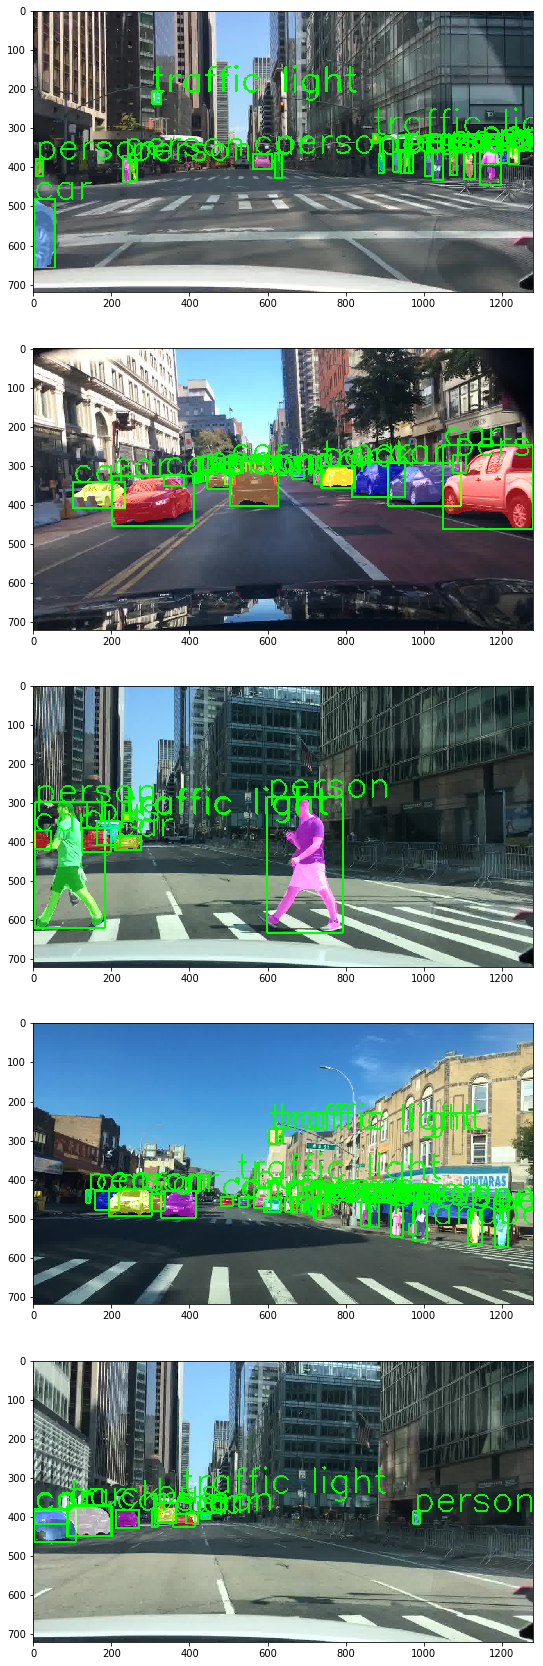

In [9]:
fig, axes = plt.subplots(len(images_files),1, figsize=(20,30))
[instance_segmentation(f,ax) for ax,f in zip(axes,images_files)]     
plt.show()